## Аналіз A/B-тестів

Ви - аналітик даних в ІТ-компанії і до вас надійшла задача проаналізувати дані A/B тесту в популярній [грі Cookie Cats](https://www.facebook.com/cookiecatsgame). Це - гра-головоломка в стилі «з’єднай три», де гравець повинен з’єднати плитки одного кольору, щоб очистити дошку та виграти рівень. На дошці також зображені співаючі котики :)

Під час проходження гри гравці стикаються з воротами, які змушують їх чекати деякий час, перш ніж вони зможуть прогресувати або зробити покупку в додатку.

У цьому блоці завдань ми проаналізуємо результати A/B тесту, коли перші ворота в Cookie Cats було переміщено з рівня 30 на рівень 40. Зокрема, ми хочемо зрозуміти, як це вплинуло на утримання (retention) гравців. Тобто хочемо зрозуміти, чи переміщення воріт на 10 рівнів пізніше якимось чином вплинуло на те, що користувачі перестають грати в гру раніше чи пізніше з точки зору кількості їх днів з моменту встановлення гри.

Будемо працювати з даними з файлу `cookie_cats.csv`. Колонки в даних наступні:

- `userid` - унікальний номер, який ідентифікує кожного гравця.
- `version` - чи потрапив гравець в контрольну групу (gate_30 - ворота на 30 рівні) чи тестову групу (gate_40 - ворота на 40 рівні).
- `sum_gamerounds` - кількість ігрових раундів, зіграних гравцем протягом першого тижня після встановлення
- `retention_1` - чи через 1 день після встановлення гравець повернувся і почав грати?
- `retention_7` - чи через 7 днів після встановлення гравець повернувся і почав грати?

Коли гравець встановлював гру, його випадковим чином призначали до групи gate_30 або gate_40.

### Формулювання гіпотези

Оскільки заздалегідь невідомо, як саме переміщення воріт на 10 рівнів вплине на утримання гравців, ми проведемо **двосторонній тест**:

$$H_0: p_{30} = p_{40}$$
$$H_a: p_{30} \ne p_{40}$$

де $p_{30}$ і $p_{40}$ позначають retention rate з воротами на 30 рівні і на 40 рівні відповідно. 
Рівень значущості встановимо на рівні:
$$\alpha = 0.05$$


In [1]:
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

1. Для початку, уявімо, що ми тільки плануємо проведення зазначеного А/B-тесту і хочемо зрозуміти, дані про скількох користувачів нам треба зібрати, аби досягнути відчутного ефекту. Відчутним ефектом ми вважатимемо збільшення утримання на 1% після внесення зміни. Обчисліть, скільки користувачів сумарно нам треба аби досягнути такого ефекту, якщо продакт менеджер нам повідомив, що базове утримання є 19%.

In [2]:
effect_size = sms.proportion_effectsize(0.2, 0.19)
effect_size

np.float64(0.025241594409087353)

In [3]:
required_n = sms.NormalIndPower().solve_power(
    effect_size,
    power=0.8,
    alpha=0.05,
    ratio=1
    )
required_n = ceil(required_n)

print(required_n)

24638


Нам буде потрібно мінімум **24 638** користувачів для кожної групи, тобто приблизно **49 276** користувачів сумарно.

2. Зчитайте дані АВ тесту у змінну `df` та виведіть середнє значення показника показник `retention_7` (утримання на 7 день) по версіям гри. Сформулюйте гіпотезу: яка версія дає краще утримання через 7 днів після встановлення гри?

In [4]:
df = pd.read_csv("../data/cookie_cats.csv")
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [17]:
df.groupby('version')['userid'].count()

version
gate_30    44700
gate_40    45489
Name: userid, dtype: int64

In [6]:
retention_rates = df.groupby('version')['retention_7']
retention_rates = retention_rates.agg(['mean', 'std', stats.sem])
retention_rates.columns = ['retention_rate', 'std_deviation', 'std_error']


retention_rates.style.format('{:.5f}')

,retention_rate,std_deviation,std_error
version,,,
gate_30,0.19020,0.39246,0.00186
gate_40,0.18200,0.38585,0.00181


Судячи зі статистики вище, версія `gate_30` демонструє **краще утримання (19%)** через 7 днів після встановлення гри, ніж `gate_40`**(18,2%)**.

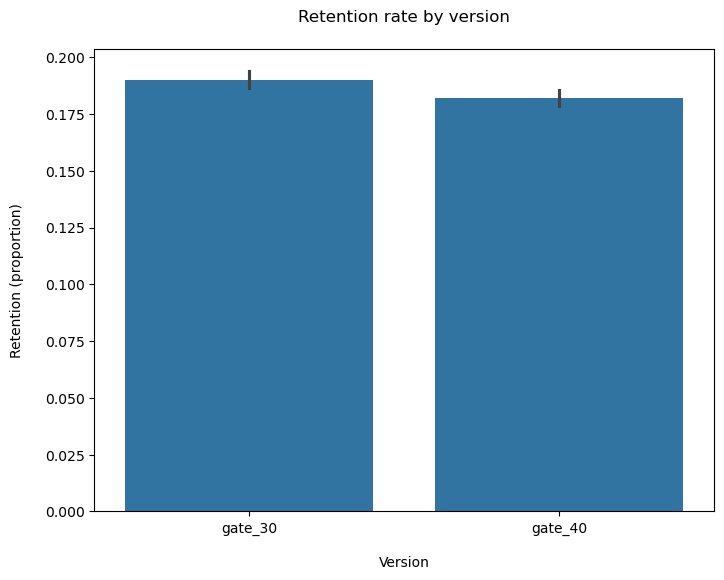

In [7]:
plt.figure(figsize=(8,6))

sns.barplot(x=df['version'], y=df['retention_7'])

plt.title('Retention rate by version', pad=20)
plt.xlabel('Version', labelpad=15)
plt.ylabel('Retention (proportion)', labelpad=15)
plt.show()

Можна припустити, що версія `gate_30` забезпечує **краще утримання** через 7 днів, ніж `gate_40`, але це потрібно підтвердити статистичним тестом.

3. Перевірте з допомогою пасуючого варіанту z-тесту, чи дає якась з версій гри кращий показник `retention_7` на рівні значущості 0.05. Обчисліть також довірчі інтервали для варіантів до переміщення воріт і після. Виведіть результат у форматі:

    ```
    z statistic: ...
    p-value: ...
    Довірчий інтервал 95% для групи control: [..., ...]
    Довірчий інтервал 95% для групи treatment: [..., ...]
    ```

    де замість `...` - обчислені значення.
    
    В якості висновку дайте відповідь на два питання:  

      1. Чи є статистична значущою різниця між поведінкою користувачів у різних версіях гри?   
      2. Чи перетинаються довірчі інтервали утримання користувачів з різних версій гри? Про що це каже?  


In [8]:
control_results = df[df['version'] == 'gate_30']['retention_7']
treatment_results = df[df['version'] == 'gate_40']['retention_7']

In [9]:
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

In [10]:
z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'Довірчий інтервал 95% для групи gate_30: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'Довірчий інтервал 95% для групи gate_40: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 3.16
p-value: 0.002
Довірчий інтервал 95% для групи gate_30: [0.187, 0.194]
Довірчий інтервал 95% для групи gate_40: [0.178, 0.186]


**Висновок:**  
1. Оскільки отримане $p$-значення=0.002 є меншим за рівень значущості $\alpha$ = 0.05, ми відхиляємо нульову гіпотезу $H_0$ про рівність показників утримання. Це означає, що існують статистично значущі докази різниці у рівні утримання користувачів через 7 днів після встановлення між версіями `gate_30` і `gate_40`.

2. Довірчі інтервали 95% для рівнів утримання не перетинаються:  
`gate_30`: [0.187, 0.194] - 18,7-19,4%,  
`gate_40`: [0.178, 0.186] - 17,8-18,6%.  
Це свідчить про вищий рівень утримання у версії `gate_30`.

**Таким чином, більш імовірно, що версія `gate_40` демонструє гірше утримання гравців через 7 днів після встановлення, ніж контрольна версія `gate_30`.**

4. Виконайте тест Хі-квадрат на рівні значущості 5% аби визначити, чи є залежність між версією гри та утриманням гравця на 7ий день після реєстрації.

    - Напишіть, як для цього тесту будуть сформульовані гіпотези.
    - Проведіть обчислення, виведіть p-значення і напишіть висновок за результатами тесту.


#### Гіпотези Хі-квадрат тесту:

$H_0:$ версія гри та утримання через 7 днів є незалежними.  
$H_a:$ між версією гри та утриманням через 7 днів існує залежність.

In [11]:
table = pd.crosstab(df['version'], df['retention_7'])
table

retention_7,False,True
version,,
gate_30,36198,8502
gate_40,37210,8279


In [12]:
chi2, p, dof, expected = stats.chi2_contingency(table)

print(f"χ² = {chi2:.3f}")
print(f"p-value = {p:.5f}")
print(f"Ступені свободи = {dof}")
print("Очікувані частоти:\n", expected)

χ² = 9.959
p-value = 0.00160
Ступені свободи = 1
Очікувані частоти:
 [[36382.90257127  8317.09742873]
 [37025.09742873  8463.90257127]]


Оскільки отримане $p$-значення=0.0016 набагато менше за рівень значущості $\alpha$ = 0.05, ми **відхиляємо гіпотезу $H_0$**. Це означає, що між версією гри та поверненням користувача на 7-ий день після встановлення **є статистично значуща залежність**. 

Так, як даний тест не визначає напрямок залежності, використаємо z-тест для уточнення напряму ефекту.

In [13]:
z_stat, pval = proportions_ztest(successes, nobs=nobs, alternative='larger') # Ha: p1 > p2
print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')

z statistic: 3.16
p-value: 0.001


Отже, результати тесту ($p$-значення=0.001) свідчать про те, що **рівень утримання у версії `gate_30` є статистично значущо вищим**, ніж у версії `gate_40`.